<a id="top_section"></a>
<div align='center'><font size="6" color="#000000"><b>Feature extraction from Dutch tweets: Exploratory Data Analysis & Application of BERT / Frog</b></font></div>
<hr>
<div align='center'><font size="5" color="#000000">A General Introduction</font></div>
<hr>

**I think we all know the power of Twitter by now. It's one of the main communications channel for most of the people on earth, we get most of our daily news through our screens via twitter in these days... With the smart phones entering in our lives our newsfeed is immense but there is one problem: How'd we know if we getting real info? What if we want to seperate real situations from the non relevant data? We're lucky! We have NLP models to do heavy work for us to get distilled info. In this notebook we're going to use some basic and common NLP approaches to give us most accurate results...**



## Table of Contents

* [Getting the Text Data Ready](#getting_the_text_data_ready)
    - [Importing Neccesary Packages](#Importing_Neccesary_Packages)
    - [Loading the Data](#Loading_the_Data)
    - [Cleaning Text](#Cleaning_Text)    
* [Visualizing the Data](#Visualizing_the_Data)
    - [Target Distribution](#Target_Distribution)
    - [Tweet Lengths](#Tweet_Lengths)
    - [Word Counts](#Word_Counts)
    - [Word Lengths](#Word_Lengths)
    - [Most Common Words](#Most_Common_Words)
    - [Most Common Bigrams](#Most_Common_Bigrams)
    - [Most Common Trigrams](#Most_Common_Trigrams)    
* [Some Extra Analysis](#Some_Extra_Analysis)
    - [Determining Topics](#Determining_Topics)
    - [Word Cloud](#Word_Cloud)
    - [Named Entity Recognition](#Named_Entity_Recognition)    
* [Building the Bert Model](#Building_the_Model)
    - [Getting Things Ready](#Getting_Things_Ready)
    - [Tokenization and Formatting the Inputs](#Tokenization_and_Formatting_the_Inputs)
    - [Setting the Bert Classification Model](#Setting_the_Bert_Classification_Model)
    - [Training and Evaluating](#Training_and_Evaluating)
    - [Predicting and Submission](#Predicting_and_Submission)
    

    

## Summary

**In this notebook I tried to apply what I learned on NLP. (Well... That's why they called notebooks right?) This notebook includes: Preprocessing the text, visualizing the processed data by several methods like tweet lenghts, word counts, average word lengths, ngrams etc. I especially wanted to clean data before I visualize it, perhaps you should investigate the raw data you got first then move to cleaning in normal cases but I didn't want to pile it on so I went this way. Then I used some more analysis tecniques like Word Clouds, NER's etc. to give us different angles to look from. At the last part we're going to implement BERT model to do tokenization, classification and prediction with using transformers. I hope this notebook helps some of you as others helped me a lot. I'll talk about them in next chapter.**

## References:

- [BERT Research from  Chris McCormick](https://www.youtube.com/watch?v=FKlPCK1uFrc): It was a great tutorial and helped me a lot through modelling part.
- [The Official BERT Paper](https://arxiv.org/pdf/1810.04805.pdf): It's helpful for understanding theory behind it also I used it while finetuning the model
- [Transformers Official Page](https://huggingface.co/transformers/quickstart.html): There are some good examples to write your own models.
- [Word Cloud GitHub Page](https://github.com/amueller/word_cloud): Again good examples for your word clouds.
- [Exploratory Data Analysis for NLP from Shahul Es](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools): Learned a lot about NLP EDA's here.
- [NLP | Exploratory Data Analysis of Text Data from Kamil Mysiak](https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d): Again this EDA work was great example for me.



<a id="Importing_Neccesary_Packages"></a>

## Importing Neccesary Packages

### **First we gonna load lots of libraries we are going to use them through our notebook. I tried to sort and group them by the use (divided by #'s) so I hope it's easier to read for you.**

### [Back To Table of Contents](#top_section)

In [53]:
# Most basic stuff for EDA and Import
from IPython.display import clear_output
import pymysql
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports to increase the visibility of the apply function progress and the ability to run functions on multiple cpu cores.
from tqdm import tqdm
tqdm.pandas()
import multiprocessing
from functools import partial

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

from nltk.corpus import stopwords
from nltk.probability import FreqDist

stopword_list = stopwords.words('dutch') # + ['amsterdam']

import spacy
nlp = spacy.load("nl_core_news_md", exclude=['ner'])
# source NER from the same pipeline package as the last component
nlp.add_pipe("ner", source=spacy.load("nl_core_news_md"))

# insert the entity ruler
nlp.add_pipe("entity_ruler", before="ner")

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches


# Setting some options for general use.

plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

# clear_output()

In [54]:
def _df_split(tup_arg, **kwargs):
    split_ind, df_split, df_f_name = tup_arg
    return (split_ind, getattr(df_split, df_f_name)(**kwargs))

def df_multi_core(df, df_f_name, subset=None, njobs=-1, **kwargs):
    if njobs == -1:
        njobs = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=njobs)

    try:
        splits = np.array_split(df[subset], njobs)
    except ValueError:
        splits = np.array_split(df, njobs)

    pool_data = [(split_ind, df_split, df_f_name) for split_ind, df_split in enumerate(splits)]
    results = pool.map(partial(_df_split, **kwargs), pool_data)
    pool.close()
    pool.join()
    results = sorted(results, key=lambda x:x[0])
    results = pd.concat([split[1] for split in results])
    return results



<a id="Loading_the_Data"></a>
## Loading the Data

### **The tweets will be imported from the trollrensics database, based on three values: investigation, begin and end date.**

#### After loading the train and test data, I added "v"'s at the end of our variables for visualization because some of the pre-processing are not needed for the modelling but we can use them for our EDA part. Anyways let's look at our given data:

#### Well... We have keywords, locations, text and our target labels. We gonna use the text feature for our modelling here.

### [Back To Table of Contents](#top_section)

In [55]:
# Create a dataframe from the sql query
def create_dataframe(begindate, enddate, investigation):
    con = pymysql.connect(
        host='127.0.0.1', 
        user='user',
        password='password', 
        database='trollrensics')

    sql = f"""
      select p.platform, p.uniqueid, p.message, p.platform_created_at, p.topic_uniqueid, p.reply_uniqueid, p.share_uniqueid, p.like_cnt, p.reply_cnt, p.quote_cnt, p.share_cnt,
          p.trollrensics_metadata,
          pr.uniqueid AS profile_uniqueid, pr.username, pr.fullname, pr.followers_cnt, pr.following_cnt, pr.posts_cnt, pr.platform_metadata
      from posts p
      left join profiles pr on pr.id = p.profile_id
      left join investigation_post ip on ip.post_id = p.id
      left join investigations i on i.id = ip.investigation_id
      where p.platform_created_at > '{begindate}' and p.platform_created_at < '{enddate}'
        and i.slug in('{investigation}')
    """

    df = pd.read_sql(sql, con)
    df['Investigation'] = investigation
    print(df.shape)
    
    return df

In [56]:
frames = []

begindate = '2020-09-01'
enddate = '2021-05-01'
investigation = 'museumplein-druktebeeld'
frames.append(create_dataframe(begindate, enddate, investigation))

investigation = 'dedam-druktebeeld'
frames.append(create_dataframe(begindate, enddate, investigation))

investigation = 'vondelpark-druktebeeld'
frames.append(create_dataframe(begindate, enddate, investigation))

df = pd.concat(frames)
df.drop_duplicates(subset='uniqueid', inplace=True)


(42241, 20)
(22756, 20)
(17701, 20)


In [57]:
mask = df.message.duplicated(keep=False)
mask.value_counts()


False    78933
True      2398
Name: message, dtype: int64

In [58]:
# Transform the date column to remove the time and only show dates
df['date'] = pd.to_datetime(df['platform_created_at']).dt.date

# df['platform_created_at'] = df['platform_created_at'].dt.strftime('%d/%m/%Y')

# Drop the columns that are not needed for this research based on following reasons:
# platform: Twitter is the only platform to be considered for this data
# trollresnsics_metadata & platform_metadata: both contain a lot of null-values and do not provide usefull information for this research
# username & fullname: This research does not need the account names, only the given unique id's. This way the project is also anonymized

df.drop(columns=['platform', 'platform_created_at', 'trollrensics_metadata', 'username', 'fullname', 'platform_metadata'], inplace=True)
df.rename(columns={"message": "text"}, inplace=True)
df.reset_index(drop=True, inplace=True)

df.info()
df.to_csv('raw_tweets.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81331 entries, 0 to 81330
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uniqueid          81331 non-null  object
 1   text              81331 non-null  object
 2   topic_uniqueid    81331 non-null  object
 3   reply_uniqueid    35661 non-null  object
 4   share_uniqueid    0 non-null      object
 5   like_cnt          81331 non-null  int64 
 6   reply_cnt         81331 non-null  int64 
 7   quote_cnt         81331 non-null  int64 
 8   share_cnt         81331 non-null  int64 
 9   profile_uniqueid  81331 non-null  object
 10  followers_cnt     81331 non-null  int64 
 11  following_cnt     81331 non-null  int64 
 12  posts_cnt         81331 non-null  int64 
 13  Investigation     81331 non-null  object
 14  date              81331 non-null  object
dtypes: int64(7), object(8)
memory usage: 9.3+ MB


<a id="Cleaning_Text"></a>
## Cleaning Text

#### Before the visualization of the text data I wanted to make it look better with some general helper functions to clear out things like: urls, hashtags, mentions and punctuations... We'll add all of them in one column called 'text_clean' then move from there for next steps. When we have cleaner text we can apply our tokenizer to split each word into a token. I'll apply this and next steps to individual columns to show each step of our progress. Next we transforming all words to lowercase then we remove stopwords (they don't mean much in sentence alone) so we use NLTK stopwords for it.

#### After removing these words we gonna lemmatize them but for that we need to add some extra steps to do it properly: We gonna apply part of speech tags to our text (like verb, noun etc.) then we convert them to wordnet format and finally we can apply lemmatizer and save it to 'lemmatized' column. And one last thing we convert these tokenized lists back to str version for future uses.

#### So basically what we did are:
- Removed urls, emojis, html tags and punctuations,
- Tokenized the tweet base texts,
- Lower cased clean text,
- Removed stopwords,
- Applied part of speech tags,
- Converted part of speeches to wordnet format,
- Applying word lemmatizer,
- Converted tokenized text to string again.


### [Back To Table of Contents](#top_section)

In [86]:
# Function that returns the lemmatized text, pos-tags and named entities for a tweet. 
def tweet_extraction(row):
    doc =nlp(row['only_words'])

    data  = [(t.text, t.lemma_, t.pos_, t.lemma_.lower()) for t in doc if not t.is_stop]
    # row['spacy_text'], row['lemma'], row['pos']  = [(t.text, t.lemma_, t.pos_) for t in doc if t.lemma_ not in stopword_list]
    spacy_text = []
    lemma = []
    pos = []
    lemma_low = []

    for x in data:
        spacy_text.append(x[0])
        lemma.append(x[1])
        pos.append(x[2])
        lemma_low.append(x[3])
    row['spacy_text'] = spacy_text
    row['lemma'] = lemma
    row['pos'] = pos
    row['lemma_low'] = lemma_low
    row['ents'] = [(e.text, e.label_) for e in doc.ents]

    return row


In [87]:
def make_hashtag_nice(tag):
    table = str.maketrans('x', 'x', string.punctuation)
    clean_text = tag.translate(table)
    new_clean = clean_text.replace("\n", ' ')
    clean = new_clean.split(' ')
    clean = clean[0].lower()

    return clean


In [88]:
# This is for testing only

df_test = df.iloc[:2000]
df_test

,uniqueid,text,topic_uniqueid,reply_uniqueid,share_uniqueid,like_cnt,reply_cnt,quote_cnt,share_cnt,profile_uniqueid,followers_cnt,following_cnt,posts_cnt,Investigation,date
0,1376795456186032128,@RHvL88 Het is maar een stief kwartiertje lope...,1376793859896844291,1376793859896844291,None,1,0,0,0,36447473,29475,1724,212683,museumplein-druktebeeld,2021-03-30
1,1376793687477391361,Amsterdam | #Grachtengordel #wanddecoratie\n1...,1376793687477391361,None,None,0,0,0,0,816668454950490112,89,192,993,museumplein-druktebeeld,2021-03-30
2,1376801305084198914,@AT5 het museumplein is een hele leuke lokatie...,1376761700091887617,1376761700091887617,None,1,0,0,0,227119302,39,30,1901,museumplein-druktebeeld,2021-03-30
3,1376800177332314113,@rivliv NL leuk oefenveld: vreedzame burgers d...,1376656349157851136,1376656349157851136,None,0,0,0,1,2914267607,784,1384,3864,museumplein-druktebeeld,2021-03-30
4,1376792135454883844,"Demonstreren op het #museumplein, #klimaatalar...",1376792135454883844,None,None,2,0,0,1,244509097,751,867,12495,museumplein-druktebeeld,2021-03-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1376262673952825348,Zo herkenbaar dit. Ik werd laatst ook geweiger...,1376262673952825348,None,None,15,2,1,2,49319243,5360,2173,33478,museumplein-druktebeeld,2021-03-28
1996,1376262413025165319,@MarijnissenL We hebben vaak kritiek op landen...,1376121609820504064,1376121609820504064,None,16,3,0,7,153776534,11457,12600,497825,museumplein-druktebeeld,2021-03-28
1997,1376262767431319555,"@JDTVproducties @drsmichakat Nee hoor, ze wijz...",1376216450977968130,1376261957775425540,None,1,0,0,0,1249328291313483776,45,11,5421,museumplein-druktebeeld,2021-03-28
1998,1376262741225312258,@lammert We hebben vaak kritiek op landen waar...,1376098406897172480,1376098406897172480,None,4,1,1,0,153776534,11457,12600,497825,museumplein-druktebeeld,2021-03-28


In [91]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.
SYMBOLS = ['~', ':', "'", '+', '[', '\\', '@', '^', '{', '%', '(', '-', '"', '*', '|', ',', '&', '<', '`', '}', '_', '=', ']', '!', '>', ';', '?', '#', '$', ')', '/']

def clean_all(row):
    text = row['text']
    mentions = []
    hashtags = []
    urls = []
    only_words = ''
    only_words_lower = ''
    words = text.split(' ')

    for word in words:
        if word.startswith('@'):
            cleaned = make_hashtag_nice(word)
            mentions.append(cleaned)
            temp_word = f'mention{cleaned}'
            only_words += f'{temp_word} '
        elif word.startswith('#'):
            cleaned = make_hashtag_nice(word)
            hashtags.append(cleaned)
            temp_word = f'hastag{cleaned}'
            only_words += f'{temp_word} '
        elif word.startswith('https?://') or word.startswith('www\.'):
            urls.append(word)
        else:
            if word not in SYMBOLS:
                only_words += f'{word} '

#     table = str.maketrans('', '', string.punctuation)
#     clean_text = text.translate(table)
    clean_text = re.sub(r'[^\w\s]', '', only_words)
    clean_text = clean_text.strip('\\n')
    row['only_words'] = clean_text
    row = tweet_extraction(row)

    row['mentions'] = mentions
    row['hashtags'] = hashtags
    row['urls'] = urls
    row['len_mentions'] = len(mentions)
    row['len_hashtags'] = len(hashtags)
    row['len_urls'] = len(urls)
    row['lower'] = clean_text.lower()
    return row

df_text = df_multi_core(df=df_test, df_f_name='progress_apply', subset=['text'],njobs=-1, func=clean_all, axis=1)

total_df.head()

100%|██████████| 250/250 [00:13<00:00, 18.83it/s]


,uniqueid,text,topic_uniqueid,reply_uniqueid,share_uniqueid,like_cnt,reply_cnt,quote_cnt,share_cnt,profile_uniqueid,followers_cnt,following_cnt,posts_cnt,Investigation,date,clean_text,spacy_text,lemma,pos,lemma_low,ents,mentions,hashtags,urls,len_mentions,len_hashtags,len_urls,lower
0,1376795456186032128,@RHvL88 Het is maar een stief kwartiertje lope...,1376793859896844291,1376793859896844291,None,1,0,0,0,36447473,29475,1724,212683,museumplein-druktebeeld,2021-03-30,RHvL88 Het is maar een stief kwartiertje lopen...,"[RHvL88, stief, kwartiertje, lopen, Rokin, Mus...","[rhvl88, stief, kwartier, lopen, rokin, museum...","[PROPN, NOUN, NOUN, VERB, NOUN, PROPN]","[rhvl88, stief, kwartier, lopen, rokin, museum...","[(Rokin, LOC), (Museumplei, LOC)]",[rhvl88],[],[],1.0,0.0,0.0,rhvl88 het is maar een stief kwartiertje lopen...
1,1376793687477391361,Amsterdam | #Grachtengordel #wanddecoratie\n1...,1376793687477391361,None,None,0,0,0,0,816668454950490112,89,192,993,museumplein-druktebeeld,2021-03-30,Amsterdam Grachtengordel wanddecoratie\n10 L...,"[Amsterdam, , Grachtengordel, , wanddecorati...","[amsterdam, , grachtengordel, , wanddecorati...","[PROPN, SPACE, NOUN, SPACE, NOUN, SPACE, NUM, ...","[amsterdam, , grachtengordel, , wanddecorati...","[(Amsterdam, GPE), (Grachtengordel, FAC), (10,...",[],"[grachtengordel, wanddecoratie, lentekorting, ...",[],0.0,17.0,0.0,amsterdam grachtengordel wanddecoratie\n10 l...
2,1376194425102209029,Amsterdam | #Grachtengordel #wanddecoratie\n1...,1376194425102209029,None,None,1,0,0,0,816668454950490112,89,192,993,museumplein-druktebeeld,2021-03-28,Amsterdam Grachtengordel wanddecoratie\n10 L...,"[Amsterdam, , Grachtengordel, , wanddecorati...","[amsterdam, , grachtengordel, , wanddecorati...","[PROPN, SPACE, NOUN, SPACE, NOUN, SPACE, NUM, ...","[amsterdam, , grachtengordel, , wanddecorati...","[(Amsterdam, GPE), (Grachtengordel, FAC), (10,...",[],"[grachtengordel, wanddecoratie, lentekorting, ...",[],0.0,17.0,0.0,amsterdam grachtengordel wanddecoratie\n10 l...
3,1376801305084198914,@AT5 het museumplein is een hele leuke lokatie...,1376761700091887617,1376761700091887617,None,1,0,0,0,227119302,39,30,1901,museumplein-druktebeeld,2021-03-30,AT5 het museumplein is een hele leuke lokatie ...,"[AT5, museumplein, leuke, lokatie, , feesten,...","[at5, museumplein, leuk, lokatie, , feesten, ...","[PROPN, NOUN, ADJ, NOUN, SPACE, VERB, NOUN, VERB]","[at5, museumplein, leuk, lokatie, , feesten, ...",[],[at5],[],[],1.0,0.0,0.0,at5 het museumplein is een hele leuke lokatie ...
4,1376800177332314113,@rivliv NL leuk oefenveld: vreedzame burgers d...,1376656349157851136,1376656349157851136,None,0,0,0,1,2914267607,784,1384,3864,museumplein-druktebeeld,2021-03-30,rivliv NL leuk oefenveld vreedzame burgers daa...,"[rivliv, NL, leuk, oefenveld, vreedzame, burge...","[rivliv, nl, leuk, oefenveld, vreedzaam, burge...","[NOUN, PROPN, ADJ, VERB, ADJ, NOUN, VERB, VERB...","[rivliv, nl, leuk, oefenveld, vreedzaam, burge...","[(NL, NORP), (Kijk die generaals op het museum...",[rivliv],[],[],1.0,0.0,0.0,rivliv nl leuk oefenveld vreedzame burgers daa...


In [92]:
total_df = df.merge(df_text, how='outer')
total_df.head()

,uniqueid,text,topic_uniqueid,reply_uniqueid,share_uniqueid,like_cnt,reply_cnt,quote_cnt,share_cnt,profile_uniqueid,followers_cnt,following_cnt,posts_cnt,Investigation,date,only_words,spacy_text,lemma,pos,lemma_low,ents,mentions,hashtags,urls,len_mentions,len_hashtags,len_urls,lower
0,1376795456186032128,@RHvL88 Het is maar een stief kwartiertje lope...,1376793859896844291,1376793859896844291,None,1,0,0,0,36447473,29475,1724,212683,museumplein-druktebeeld,2021-03-30,mentionrhvl88 Het is maar een stief kwartiertj...,"[mentionrhvl88, stief, kwartiertje, lopen, Rok...","[mentionrhvl88, stief, kwartier, lopen, rokin,...","[NOUN, NOUN, NOUN, VERB, PROPN, PROPN]","[mentionrhvl88, stief, kwartier, lopen, rokin,...","[(Rokin, LOC), (Museumplein, LOC)]",[rhvl88],[],[],1.0,0.0,0.0,mentionrhvl88 het is maar een stief kwartiertj...
1,1376793687477391361,Amsterdam | #Grachtengordel #wanddecoratie\n1...,1376793687477391361,None,None,0,0,0,0,816668454950490112,89,192,993,museumplein-druktebeeld,2021-03-30,Amsterdam hastaggrachtengordel hastagwanddeco...,"[Amsterdam, hastaggrachtengordel, , hastagwan...","[amsterdam, hastaggrachtengordel, , hastagwan...","[PROPN, NOUN, SPACE, NOUN, NOUN, NOUN, ADP, NU...","[amsterdam, hastaggrachtengordel, , hastagwan...","[(Amsterdam, GPE), (5 april 2021, DATE), (Amst...",[],"[grachtengordel, wanddecoratie, lentekorting, ...",[],0.0,17.0,0.0,amsterdam hastaggrachtengordel hastagwanddeco...
2,1376194425102209029,Amsterdam | #Grachtengordel #wanddecoratie\n1...,1376194425102209029,None,None,1,0,0,0,816668454950490112,89,192,993,museumplein-druktebeeld,2021-03-28,Amsterdam hastaggrachtengordel hastagwanddeco...,"[Amsterdam, hastaggrachtengordel, , hastagwan...","[amsterdam, hastaggrachtengordel, , hastagwan...","[PROPN, NOUN, SPACE, NOUN, NOUN, NOUN, ADP, NU...","[amsterdam, hastaggrachtengordel, , hastagwan...","[(Amsterdam, GPE), (5 april 2021, DATE), (Amst...",[],"[grachtengordel, wanddecoratie, lentekorting, ...",[],0.0,17.0,0.0,amsterdam hastaggrachtengordel hastagwanddeco...
3,1376801305084198914,@AT5 het museumplein is een hele leuke lokatie...,1376761700091887617,1376761700091887617,None,1,0,0,0,227119302,39,30,1901,museumplein-druktebeeld,2021-03-30,mentionat5 het museumplein is een hele leuke l...,"[mentionat5, museumplein, leuke, lokatie, , f...","[mentionat5, museumplein, leuk, lokatie, , fe...","[NOUN, NOUN, ADJ, NOUN, SPACE, VERB, NOUN, VERB]","[mentionat5, museumplein, leuk, lokatie, , fe...","[(mentionat5, PRODUCT)]",[at5],[],[],1.0,0.0,0.0,mentionat5 het museumplein is een hele leuke l...
4,1376800177332314113,@rivliv NL leuk oefenveld: vreedzame burgers d...,1376656349157851136,1376656349157851136,None,0,0,0,1,2914267607,784,1384,3864,museumplein-druktebeeld,2021-03-30,mentionrivliv NL leuk oefenveld vreedzame burg...,"[mentionrivliv, NL, leuk, oefenveld, vreedzame...","[mentionrivliv, nl, leuk, oefenveld, vreedzaam...","[PROPN, PROPN, ADJ, VERB, ADJ, NOUN, VERB, VER...","[mentionrivliv, nl, leuk, oefenveld, vreedzaam...","[(NL, NORP), (Kijk die generaals op het museum...",[rivliv],[],[],1.0,0.0,0.0,mentionrivliv nl leuk oefenveld vreedzame burg...


In [93]:
# Split the dataframes into 90% for training (80%) plus validation (10%) purposes and 10% for testing

mask = total_df['date'] <= dt.date(2021,4,8)
trainv = total_df.loc[mask]
testv = total_df.drop(trainv.index)

trainv.reset_index(drop=True)
testv.reset_index(drop=True)
print(total_df.shape)
print(trainv.shape)
print(testv.shape)

<IPython.core.display.Javascript object>

(82405, 28)
(74106, 28)
(8299, 28)


In [94]:
# Taking general look at the both datasets.
# trainv.to_csv('tweet_csv_train.csv')
# testv.to_csv('tweet_csv_test.csv')
total_df.to_csv('temporary_df_groot.csv')
display(trainv.sample(5))
display(testv.sample(5))


,uniqueid,text,topic_uniqueid,reply_uniqueid,share_uniqueid,like_cnt,reply_cnt,quote_cnt,share_cnt,profile_uniqueid,followers_cnt,following_cnt,posts_cnt,Investigation,date,only_words,spacy_text,lemma,pos,lemma_low,ents,mentions,hashtags,urls,len_mentions,len_hashtags,len_urls,lower
11912,1373651057612623874,Vinden jullie Nederland ook zo'n TERINGBENDE? ...,1373651057612623874,None,None,2,1,0,0,1308147614475603973,16,168,83,museumplein-druktebeeld,2021-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30559,1379165428413566977,"Zo dan verhuist, mooi plekje kijkend op het mu...",1379165428413566977,None,None,6,0,0,0,1310841797258760192,376,271,941,museumplein-druktebeeld,2021-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37977,1358361573539139584,BM Halsema gooit Museumplein weer op slot http...,1358361573539139584,None,None,1,0,0,2,801534350558892032,2920,3120,249580,museumplein-druktebeeld,2021-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1571,1376555419183820801,@__rabbithole__ Dank je.\n\nFeestvieren op het...,1376241143260794886,1376389438603943936,None,1,0,0,0,823336063,851,399,18730,museumplein-druktebeeld,2021-03-29,mentionrabbithole Dank je\n\nFeestvieren op he...,"[mentionrabbithole, Dank, \n\n, Feestvieren, M...","[mentionrabbithole, danken, \n\n, feestvieren,...","[NOUN, VERB, SPACE, PROPN, NOUN, VERB, VERB, S...","[mentionrabbithole, danken, \n\n, feestvieren,...","[(Dank je, ORG), (Museumplein, FAC), (Bang ben...",[rabbithole],[],[],1.0,0.0,0.0,mentionrabbithole dank je\n\nfeestvieren op he...
17404,1373276329982976001,De 'maar weinig doden' zijn resultaat van #cor...,1373276329982976001,None,None,0,2,1,0,759922975198117888,114,3,13361,museumplein-druktebeeld,2021-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,uniqueid,text,topic_uniqueid,reply_uniqueid,share_uniqueid,like_cnt,reply_cnt,quote_cnt,share_cnt,profile_uniqueid,followers_cnt,following_cnt,posts_cnt,Investigation,date,only_words,spacy_text,lemma,pos,lemma_low,ents,mentions,hashtags,urls,len_mentions,len_hashtags,len_urls,lower
40249,1385936691739963392,@Monte_Lanaco @tweetlelidy Diepe zucht. Dat ze...,1385665061528743944,1385845656519155712,None,3,0,0,0,1033709287107977217,4838,3964,57443,museumplein-druktebeeld,2021-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63725,1386390662053040130,Je kunt tegen het coronabeleid zijn maar je be...,1386390662053040130,None,None,3,1,0,1,3156576852,1991,1915,104963,dedam-druktebeeld,2021-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81006,1387028831081533441,"Lieve Heer, kunt u misschien even een plaatsel...",1387028831081533441,None,None,52,6,1,8,1312427609486241792,1481,712,8229,vondelpark-druktebeeld,2021-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52826,1383596479034445835,Se acuerdan en el velatorio de DAM les dieron ...,1383596479034445835,None,None,1,0,0,0,163992090,363,803,46382,dedam-druktebeeld,2021-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52758,1383301071603310594,@Steven_VdB80 Als A onzinnig vindt dat terrass...,1382768561127616517,1383299650581504026,None,0,0,0,0,1179754549256556545,360,865,2334,dedam-druktebeeld,2021-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id="Visualizing_the_Data"></a>
# Visualizing the Data

#### Well... Our text is ready for inspection, clean and in order. We can start visualizing the data to see if we can find some visible relations between tweet classes.

### [Back To Table of Contents](#top_section)

<a id="Target_Distribution"></a>
## Target Distribution

#### When we check our target variables and look at how they disturbuted we can say it not bad. There is no huge difference between classes we can say it's good sign for modelling.

### [Back To Table of Contents](#top_section)

KeyError: 'crowded'

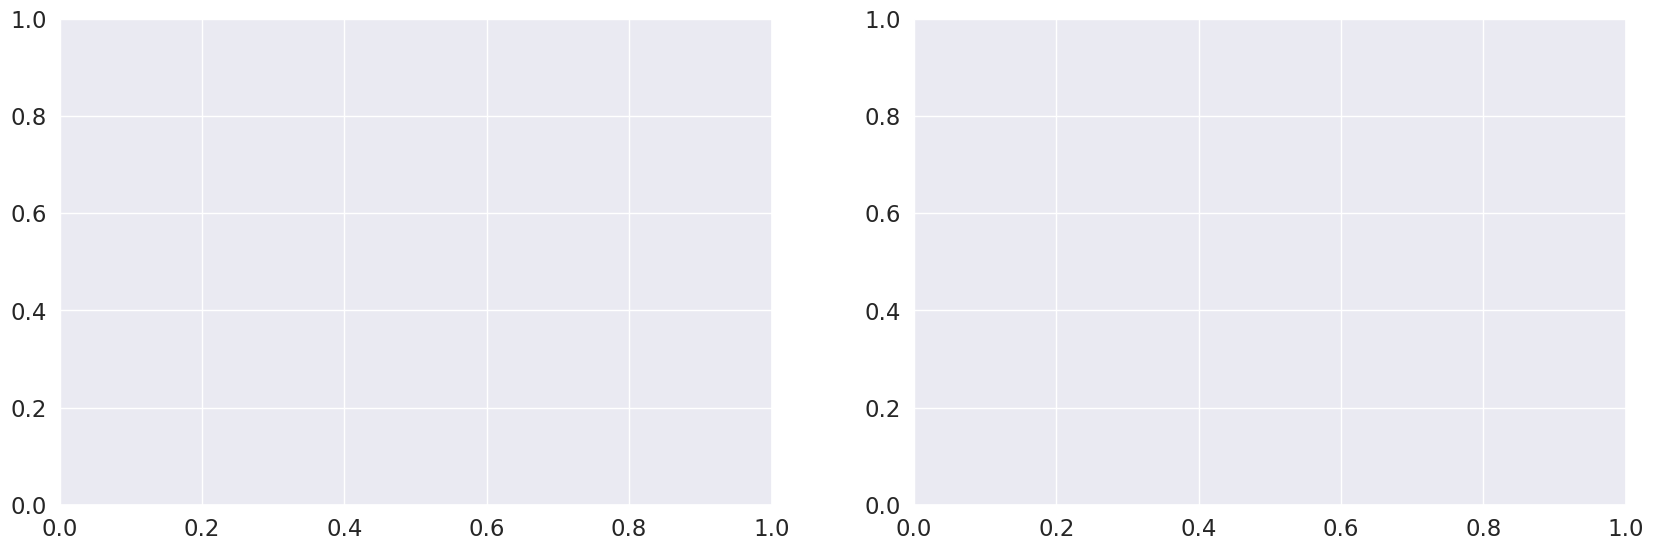

In [23]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(trainv['crowded'], ax=axes[0])
axes[1].pie(trainv['crowded'].value_counts(),
            labels=['No event', 'Event'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

<a id="Tweet_Lengths"></a>
## Tweet Lengths

#### Let's start with the number of characters per tweet and compare if it's disaster related or not. It seems disaster tweets are longer than non disaster tweets in general. We can assume longer tweets are more likely for disasters but this is only an assumption and might be not true...

### [Back To Table of Contents](#top_section)

In [ ]:
# Creating a new feature for the visualization.

trainv['Character Count'] = trainv['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

In [ ]:
plot_dist3(trainv[trainv['crowded'] == 1], 'Character Count',
           'Characters Per Event Tweets')

In [ ]:
plot_dist3(trainv[trainv['crowded'] == 0], 'Character Count',
           'Characters Per No Event Tweets')

In [ ]:
plot_dist3(trainv[trainv['Investigation'] == 'museumplein-druktebeeld'], 'Character Count',
           'Characters Per "Museumplein" Tweets')

In [ ]:
plot_dist3(trainv[trainv['Investigation'] == 'dedam-druktebeeld'], 'Character Count',
           'Characters Per "Dam Square" Tweets')

In [ ]:
plot_dist3(trainv[trainv['Investigation'] == 'vondelpark-druktebeeld'], 'Character Count',
           'Characters Per "Vondelpark" Tweets')

<a id="Word_Counts"></a>
## Word Counts

#### Ok let's check number of words per tweet now, they both look somewhat normally distributed, again disaster tweets seems to have slightly more words than non disaster ones. We might dig this deeper to get some more info in next part...

### [Back To Table of Contents](#top_section)

In [ ]:
def plot_word_number_histogram(plot1, plot2, plot3):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(plot1.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(plot2.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(plot3.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Vondelpark')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Museumplein')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('De Dam')

    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

In [ ]:
plot_word_number_histogram(trainv[trainv['Investigation'] == 'vondelpark-druktebeeld']['text'],
                           trainv[trainv['Investigation'] == 'museumplein-druktebeeld']['text'],
                           trainv[trainv['Investigation'] == 'dedam-druktebeeld']['text'])

<a id="Word_Lengths"></a>
## Word Lengths

#### This time we're gonna check if word complexity differs from tweet class. It looks like disaster tweets has longer words than non disaster ones in general. It's pretty visible which is good sign, yet again we can only assume at this stage...

### [Back To Table of Contents](#top_section)

In [ ]:
def plot_word_len_histogram(textno, textye):
    
    """A function for comparing average word length"""
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('No Event Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Event Tweets')
    
    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()
    

In [ ]:
plot_word_len_histogram(trainv[trainv['crowded'] == 0]['text'],
                        trainv[trainv['crowded'] == 1]['text'])

In [ ]:
lis = [
    trainv[trainv['crowded'] == 0]['lemma_str'],
    trainv[trainv['crowded'] == 1]['lemma_str']
]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df = pd.DataFrame([x, y]).T
        df = df.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

<a id="Most_Common_Words"></a>
## Most Common Words

#### It's time to move to words themselves instead of their quantitative features. We start with most common words in both classes. I'd say it's pretty obvious if it's from disaster tweets or not. Disaster tweets has words like fire, kill, bomb indicating disasters. Meanwhile non disaster ones looks like pretty generic.


### [Back To Table of Contents](#top_section)

In [ ]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('No Event Tweets')

axes[1].set_title('Event Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [ ]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Event Tweets')
        axes[1].set_title('No Event Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

<a id="Most_Common_Bigrams"></a>
## Most Common Bigrams

#### Let's have a look for bigrams this time, which they are sequences of adjacent two words. Again it's pretty obvious to seperate two classes if it's disaster related or not. There are some confusing bigrams in non disaster ones like  body bag, emergency service etc. which needs deeper research but we'll leave it here since we got what we looking for in general.

### [Back To Table of Contents](#top_section)

In [ ]:
ngrams(2, 'Most Common Bigrams')

<a id="Most_Common_Trigrams"></a>
## Most Common Trigrams

#### Alright! Things are much clearer with sequences of 3 words. The confusing body bags were cross body bags (Who uses them in these days anyways!) which I found it pretty funny when I found the reason of the confusion. Anyways we can see disasters are highly seperable now from non disaster ones, which is great!

### [Back To Table of Contents](#top_section)

In [ ]:
ngrams(3, 'Most Common Trigrams')

<a id="Some_Extra_Analysis"></a>
# Some Extra Analysis

#### In this part we gonna apply some other analysis tecniques to gain some more insights about our dataset let's see what we can get from them...

### [Back To Table of Contents](#top_section)

<a id="Determining_Topics"></a>
## Determining Topics

#### We'll be using a method called Non-Negative Matrix Factorization (NMF) to see if we can get some defined topics out of our TF-IDF matrix, with this way TF-IDF will decrease impact of the high frequency words, so we might get more specific topics.

#### When we inspect our top ten topics we might need to use little imagination to help us understand them. Well actually they are pretty seperable again, I'd say disaster topics are much more clearer to read, we can see the topics directly by looking at them, meanwhile non disaster ones are more personal topics...

### [Back To Table of Contents](#top_section)

In [ ]:
def display_topics(text, no_top_words, topic):
    
    """ A function for determining the topics present in our corpus with nmf """
    
    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    nmf = NMF(n_components=10, random_state=0,
              alpha=.1, init='nndsvd').fit(tfidf)
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


display_topics(lis[0], 10, 'No Event Topics\n')

In [ ]:
display_topics(lis[1], 10,'Event Topics\n')

<a id="Word_Cloud"></a>
## Word Cloud

#### Wordclouds are popular approach in NLP tasks. We're going to use the library exactly designed for it called "WordCloud", I also wanted to mask it with twitter logo shape and grey colors just for adding more interesting presentation and show what you can do with this library. When we look our word clouds we can clearly say which one is disaster on which one is not. Pretty good!

### [Back To Table of Contents](#top_section)

In [ ]:
# Setting mask for wordcloud.

mask = np.array(Image.open('/kaggle/input/twittermaskn/twittermask.png'))
mask[mask.sum(axis=2) == 0] = 255

In [ ]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.1,
        contour_color='grey',
    ).generate(str(mostcommon))    

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
plot_wordcloud(trainv[trainv['target'] == 0]['lemmatized'],
               'Most Common Words in Non-Disaster Tweets',
               title_size=30)

In [ ]:
plot_wordcloud(trainv[trainv['target'] == 1]['lemmatized'],
               'Most Common Words in Disaster Tweets',
               title_size=30)

<a id="Named_Entity_Recognition"></a>
## Named Entity Recognition

#### One last thing before we move on the modelling is Named Entity Recognition. It's a method for extracting information from text and returns which entities that are present in the text are classified into predefined entity types like "Person", "Place", "Organization", etc. By using NER we can get great insights about the types of entities present in the given text dataset.

#### When we look our NER results we can get lots of great insights. We can see that in disaster tweets countries, cities, states are much more common than non disaster ones. Again nationality or religious or political group names are more likely to be mentioned in disaster tweets. These are great indicators for us...

### [Back To Table of Contents](#top_section)

In [ ]:
# Loading NER.
nlp = en_core_web_sm.load() 

In [ ]:
def plot_named_entity_barchart(text):
    
    """A function for extracting named entities and comparing them"""
    
    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

<a id="Building_the_Model"></a>
# Building the Bert Model

#### Finally it's time to start building our model. We gonna use BERT for this task with the help of library called Transformers which makes our work much more smoother...

### [Back To Table of Contents](#top_section)

<a id="Getting_Things_Ready"></a>
## Getting Things Ready

#### Let's start with setting our main computing device. The code below automatically choose GPU if it's available otherwise goes with CPU but I highly recommend GPU which is much faster. Then we load our traning and test data for modelling, as I said I'm not going to use our visualization data, BERT uses punctuations in modelling and as you'll see BERT does great job on raw text by itself.

### [Back To Table of Contents](#top_section)

In [ ]:
# If there's a GPU available...

if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.  
    
    device = torch.device('cuda')    


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

In [ ]:
# Loading the data for modelling.

train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

display(train.sample(10))

In [ ]:
# Setting target variables, creating combined data and saving index for dividing combined data later.

labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

<a id="Tokenization_and_Formatting_the_Inputs"></a>
## Tokenization and Formatting the Inputs

#### For feeding our text to BERT we have to tokenize our text first and then these tokens must be mapped. For this job we gonna download and use BERT's own tokenizer. Thanks to Transformers library it's like one line of code, we also convert our tokens to lowercase for uncased model. You can see how the tokenizer works below there on first row of tweets for example.

#### We set our max len according to our tokenized sentences for padding and truncation, then we use tokenizer.encode_plus it'll split the sentences into tokens, then adds special tokens for classificication [CLS]: 
> The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks. (from the BERT paper)
#### Then it adds [SEP] tokens for making BERT decide if sentences are related. In our case it shouldn't be that important I think.

#### Then our tokenizer map's our tokens to their IDs first and pads or truncates all sentences to same length according to our max length. If sentence is longer than our limit it gets truncated, if it's shorter than our defined length then it adds [PAD] tokens to get them in same length.

#### Finally tokenizer create attention masks which is consisting of 1's and 0's for differentiating [PAD] tokens from the actual tokens.

#### We do these steps for each train and test set and then get our converted data for our BERT model. We also split train test on our train data for checking our models accuracy. 

#### Lastly we define how to load the data into our model for training, since we can't use it all at once because of memory restrictions. On the official BERT paper batch size of 16 or 32 is recommended so we went with 32 since Kaggle offers us decent GPU's thanks to them!

### [Back To Table of Contents](#top_section)

In [ ]:
# Tokenizing the combined text data using bert tokenizer.

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [ ]:
# Print the original tweet.

print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

In [ ]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

In [ ]:
# Making list of sentence lenghts:

token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

In [ ]:
# Displaying sentence length dist.

fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

### I choose max len of 84 since it's the longest sentence we have here, playing with this number might get different results but the bigger you choose the slower the model will be!

In [ ]:
# Splitting the train test data after tokenizing.

train= combined[:idx]
test = combined[idx:]
train.shape

In [ ]:
def tokenize_map(sentence,labs='None'):
    
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    
    global labels
    
    input_ids = []
    attention_masks = []

    # For every sentence...
    
    for text in sentence:
        #   "encode_plus" will:
        
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [ ]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.

input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks= tokenize_map(test)

In [ ]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

<a id="Setting_the_Bert_Classification_Model"></a>
## Setting the Bert Classification Model

#### It's time to load our model, exciting right?! Thanks to Transformers library we have exact tools we need for classification task. We set bert-large-uncased for the more accurate results and assign 2 labels for classification.

#### You can see the model parameters down there, it's pretty straightforward with the transformers.

#### Then we choose our optimizer and fine-tune our model. Again these hyperparameters (learning_rate, epsilon, epochs etc.) are recommended on the official BERT paper.

### [Back To Table of Contents](#top_section)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the device which we set GPU in our case.

model.to(device)

In [ ]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch).

# The 'W' stands for 'Weight Decay fix' probably...

optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 

# We chose to run for 3, but we'll see later that this may be over-fitting the training data.

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

<a id="Training_and_Evaluating"></a>
## Training and Evaluating

#### Time to train our model! First we set some helper functions to calculate our metrics and time spent on the process. Then it moves like this, directly from the original notebook, it's pretty good at explaining I shouldn't confuse you with my own way of telling I guess:


> Training:

>-    Unpack our data inputs and labels
-    Load data onto the GPU for acceleration,
-    Clear out the gradients calculated in the previous pass,
     -   In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out,
-    Forward pass (feed input data through the network),
-    Backward pass (backpropagation),
-    Tell the network to update parameters with optimizer.step(),
-    Track variables for monitoring progress.

>Evalution:

>-    Unpack our data inputs and labels,
-    Load data onto the GPU for acceleration,
-    Forward pass (feed input data through the network),
-    Compute loss on our validation data and track variables for monitoring progress.

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 


The code below trains according to our data and saves the learning progress on the way so we can summarize at the end and see our results. We can also turn these to dataframe and plot it to see our eavluation better. So we can decide if the model performs well and not overfitting...




### [Back To Table of Contents](#top_section)

In [ ]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [ ]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:

# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.

training_stats = []

# Measure the total training time for the whole run.

total_t0 = time.time()

# For each epoch...

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:
    
    t0 = time.time()

    # Reset the total loss for this epoch.
    
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    
    # `dropout` and `batchnorm` layers behave differently during training vs. test ,
    # source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    
    model.train()

    # For each batch of training data...
    
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is 'convenient while training RNNs'. 
        # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is down here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
        
        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)
        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end, 
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        
        loss.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        
        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)
        
        optimizer.step()

        # Update the learning rate.
        
        scheduler.step()

    # Calculate the average loss over all of the batches.
    
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    
    model.eval()

    # Tracking variables:
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.
    
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is down here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.
            
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        
        total_eval_loss += loss.item()

        # Move logits and labels to CPU:
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    
    # Report the final f1 score for this validation run.
    
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    # Measure how long the validation run took:
    
    validation_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))

In [ ]:
# Display floats with two decimal places.

pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.

df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.

df_stats = df_stats.set_index('epoch')

# Display the table.

display(df_stats)

In [ ]:
# Increase the plot size and font size:

fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()

<a id="Predicting_and_Submission"></a>
## Predicting and Submission

#### Ok we trained our model and it's ready to make predictions on our test data. Then we save them to csv file for submission, this part is pretty straightforward for the most of classification tasks.

### [Back To Table of Contents](#top_section)

In [ ]:
# Prediction on test set:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode:

model.eval()

# Tracking variables :

predictions = []

# Predict:

for batch in prediction_dataloader:
    
  # Add batch to GPU

  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader:
    
  b_input_ids, b_input_mask, = batch
  
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:

  with torch.no_grad():
      # Forward pass, calculate logit predictions:
    
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU:
    
  logits = logits.detach().cpu().numpy()
 
  
  # Store predictions and true labels:
    
  predictions.append(logits)


print('    DONE.')

In [ ]:
# Getting list of predictions and then choosing the target value with using argmax on probabilities.

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# Creating submission data.

submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = flat_predictions
submission.head(10)

In [ ]:
# Saving submission to '.csv' file:

submission.to_csv('submission.csv', index=False, header=True)

## Well that's it then... Thank you all for reading! I hope it helps you on the way of learning NLP. I'm completely open to feedbacks for improving my work and learning more, I'm still a beginner and learning a lot every single day so please feel free to add your opinion in the comments.
<div align='center'><font size="6" color="#000000"><b>And again please UPVOTE if you liked this notebook so it can reach more people, Thanks!</b></font></div>
